In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel
from collections import defaultdict
from sklearn.model_selection import train_test_split
from surprise import Prediction,accuracy,Dataset, Reader, SVD,SVDpp,KNNBasic,KNNWithMeans,KNNBaseline,KNNWithZScore
from sklearn.metrics.pairwise import cosine_similarity,linear_kernel
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.metrics import mean_squared_error,recall_score
from surprise.model_selection import GridSearchCV,train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import string
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Multiply, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [2]:
prime_video_df = pd.read_csv('prime_videos.csv')

In [3]:
prime_video_df.head()

,rating,title_x,text,asin,parent_asin,timestamp,verified_purchase,main_category,title_y,average_rating,rating_number,description,price,categories
0,5,Five Stars,"Amazon, please buy the show! I'm hooked!",B013488XFS,B013488XFS,2015-08-24 03:07:17.000,True,Prime Video,Sneaky Pete,4.6,56658.0,['A\xa0con man (Giovanni Ribisi) on the run fr...,NaN,Suspense
1,5,Five Stars,My Kiddos LOVE this show!!,B00CB6VTDS,B00CB6VTDS,2016-04-19 21:16:50.000,True,Prime Video,Creative Galaxy,4.8,6403.0,['Follow the adventures of Arty and his sideki...,NaN,Kids
2,5,What Love Is...,"...isn't always how you expect it to be, but w...",B001H1SVZC,B001H1SVZC,2020-05-28 04:13:47.074,True,Prime Video,NaN,4.5,389.0,NaN,NaN,NaN
3,5,QUIRKY TURNS TO HEARTSTRINGS,As you learn about the very unique characters ...,B06WVW16WY,B06WVW16WY,2020-04-16 01:15:47.540,True,Prime Video,NaN,4.8,1966.0,NaN,NaN,NaN
4,5,Way better than the harsh reviews.,Our family loved the film. We have kids and th...,B07RXM26FG,B07RXM26FG,2019-09-29 05:17:12.700,True,Prime Video,NaN,4.5,57962.0,NaN,NaN,NaN


In [4]:
prime_video_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233610 entries, 0 to 233609
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   rating             233610 non-null  int64  
 1   title_x            233586 non-null  object 
 2   text               233579 non-null  object 
 3   asin               233610 non-null  object 
 4   parent_asin        233610 non-null  object 
 5   timestamp          233610 non-null  object 
 6   verified_purchase  233610 non-null  bool   
 7   main_category      233610 non-null  object 
 8   title_y            33800 non-null   object 
 9   average_rating     233607 non-null  float64
 10  rating_number      233607 non-null  float64
 11  description        33800 non-null   object 
 12  price              24165 non-null   float64
 13  categories         33800 non-null   object 
dtypes: bool(1), float64(3), int64(1), object(9)
memory usage: 23.4+ MB


In [5]:
prime_video_info = {
    "missing_values": prime_video_df.isnull().sum(),
    "duplicates": prime_video_df.duplicated().sum()
}

prime_video_info

{'missing_values': rating                    0
 title_x                  24
 text                     31
 asin                      0
 parent_asin               0
 timestamp                 0
 verified_purchase         0
 main_category             0
 title_y              199810
 average_rating            3
 rating_number             3
 description          199810
 price                209445
 categories           199810
 dtype: int64,
 'duplicates': 538}

In [6]:
prime_video_df.drop_duplicates(inplace=True)
prime_video_df.dropna(inplace=True)

prime_video_df.head()

,rating,title_x,text,asin,parent_asin,timestamp,verified_purchase,main_category,title_y,average_rating,rating_number,description,price,categories
14,4,Four Stars,It was pretty good. Had some pretty comical sc...,B01KBKKU7G,B01KBKKU7G,2016-09-16 18:39:49.000,True,Prime Video,Seven Girlfriends,3.2,333.0,"[""Jesse has never had a problem finding a gir...",12.99,Comedy
19,3,Ok love story,A bit slow and an unsatisfying ending,B01M0S0C8M,B01M0S0C8M,2016-11-08 22:14:17.000,True,Prime Video,Still Mine,4.6,4744.0,"[""James Cromwell gives a tour de force perform...",9.99,Drama
21,1,TRASH,A movie based solely on INCEST. Storyline is g...,B00G2TAAVM,B00G2TAAVM,2022-08-22 20:06:25.847,True,Prime Video,How I Live Now,4.3,907.0,"['Set in the near-future UK, Saoirse Ronan pla...",12.99,International
27,5,Five Stars,Excellent!!!,B018HJ03UC,B018HJ03UC,2016-01-25 18:47:06.000,True,Prime Video,The Martian,4.8,45859.0,"['From legendary director Ridley Scott (Alien,...",4.99,Science Fiction
70,2,Not what it used to be,This used to be a favorite of mine but I just ...,B07FLP19K1,B07FLP19K1,2018-12-03 16:52:02.089,True,Prime Video,On The Case with Paula Zahn,4.6,141.0,['On The Case with Paula Zahn takes viewers on...,22.99,Suspense


In [7]:
prime_video_df.shape

(24112, 14)

In [8]:
prime_video_df.columns

Index(['rating', 'title_x', 'text', 'asin', 'parent_asin', 'timestamp',
       'verified_purchase', 'main_category', 'title_y', 'average_rating',
       'rating_number', 'description', 'price', 'categories'],
      dtype='object')

In [9]:
prime_video_df['categories'].value_counts()

Comedy                       5839
Suspense                     5105
Drama                        5075
Science Fiction              3214
Documentary                   958
Action                        550
Historical                    465
Unscripted                    441
Fantasy                       394
Animation                     332
Adventure                     301
Kids                          295
Horror                        270
Special Interest              160
International                 129
[                              87
Romance                        83
Sports                         73
Young Adult Audience           72
Western                        70
Arts                           57
Faith and Spirituality         32
Fitness                        23
Military and War               22
Anime                          19
Arthouse                       17
Music Videos and Concerts      15
LGBTQ                           7
Talk Show and Variety           7
Name: categori

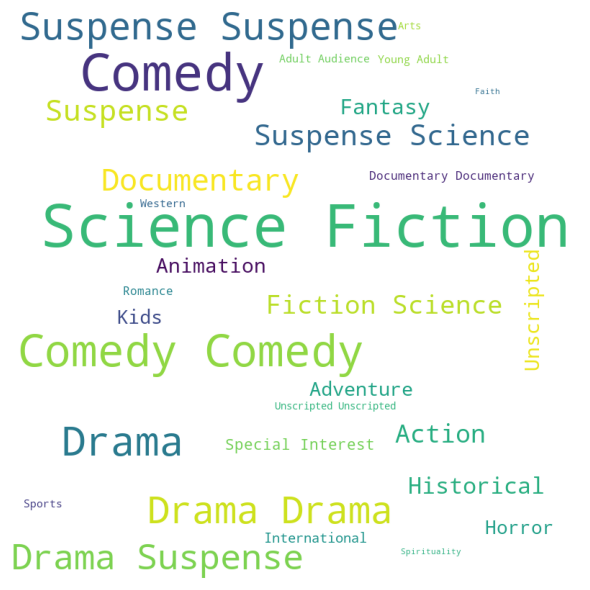

In [10]:
##create a word cloud for the categories
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(' '.join(prime_video_df['categories']))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()


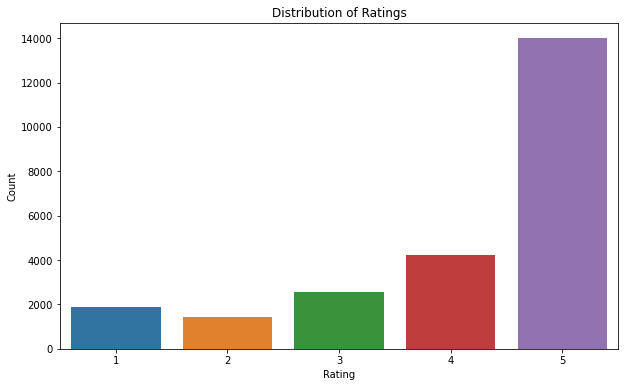

In [11]:
# Plotting the distribution of the ratings
plt.figure(figsize=(10,6))
sns.countplot(prime_video_df['rating'])
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


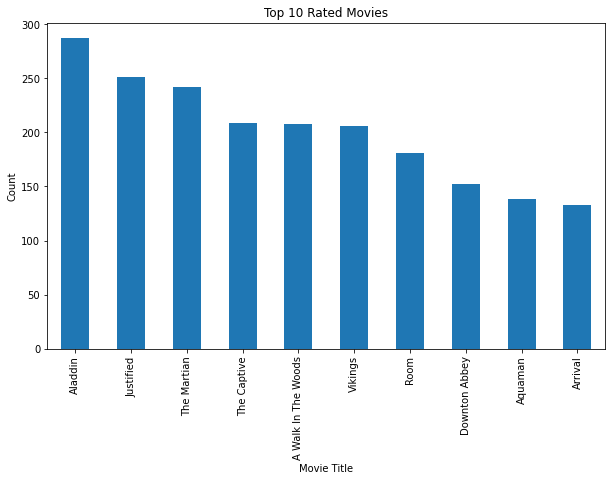

In [17]:
# Ploting top 10 rated movies
plt.figure(figsize=(10,6))
prime_video_df['title_y'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Rated Movies')
plt.xlabel('Movie Title')
plt.ylabel('Count')
plt.show()


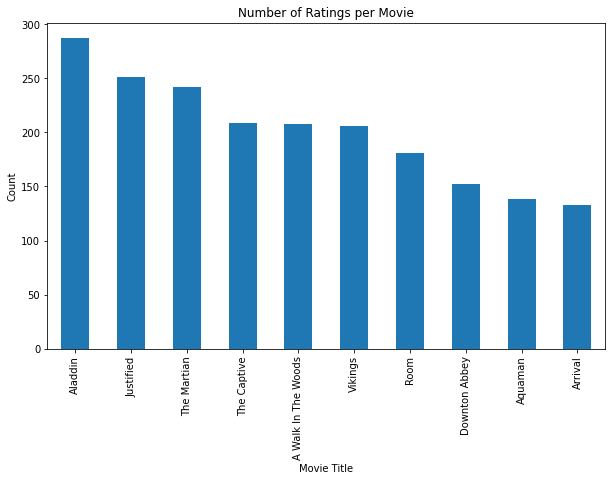

In [20]:
# calculating number of ratings per movie
ratings_per_movie = prime_video_df.groupby('title_y')['rating'].count().sort_values(ascending=False)
ratings_per_movie.head()

# ploting a bar graph for the number of ratings per movie
plt.figure(figsize=(10,6))
ratings_per_movie.head(10).plot(kind='bar')
plt.title('Number of Ratings per Movie')
plt.xlabel('Movie Title')
plt.ylabel('Count')
plt.show()




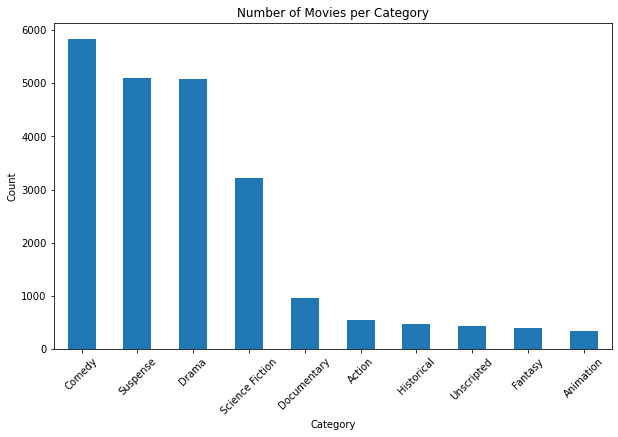

In [22]:
# Spliting categories and explode into individual rows
prime_video_df['categories'] = prime_video_df['categories'].str.split(',')
prime_video_df = prime_video_df.explode('categories')

#counting categories
categories_count = prime_video_df['categories'].value_counts()

#ploting a bar graph for the number of movies per category
plt.figure(figsize=(10,6))
categories_count.head(10).plot(kind='bar')
plt.title('Number of Movies per Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()



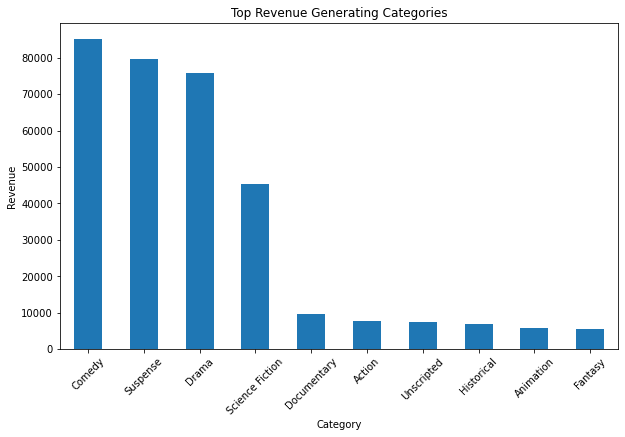

In [23]:
# Calculating top revenue generating categories
top_revenue_categories = prime_video_df.groupby('categories')['price'].sum().sort_values(ascending=False)
top_revenue_categories.head()

# Plotting top revenue generating categories
plt.figure(figsize=(10,6))
top_revenue_categories.head(10).plot(kind='bar')
plt.title('Top Revenue Generating Categories')
plt.xlabel('Category')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.show()


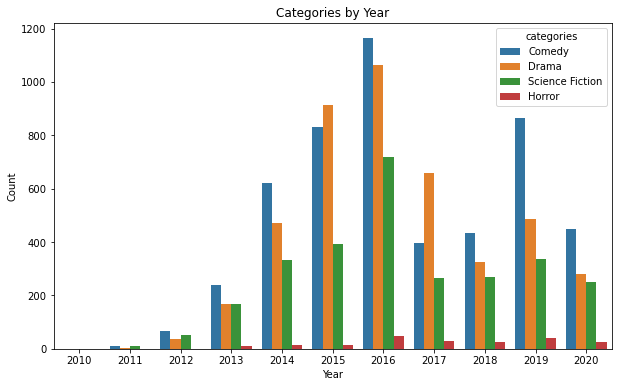

In [24]:
# Extracting release year from the timestamp
prime_video_df['release_year'] = pd.to_datetime(prime_video_df['timestamp']).dt.year


#filtering for specific categories
categories = ['Action & Adventure', 'Comedy', 'Drama', 'Horror', 'Science Fiction']
filtered_df = prime_video_df[prime_video_df['categories'].isin(categories)]

#Filtering for a specific year range
filtered_df = filtered_df[(filtered_df['release_year'] >= 2010) & (filtered_df['release_year'] <= 2020)]

#ploting categories by year
plt.figure(figsize=(10,6))
sns.countplot(x='release_year', hue='categories', data=filtered_df)
plt.title('Categories by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()